In [22]:
%load_ext autoreload
%autoreload 2

import logging
import os
from os.path import join as pj

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
from sae_lens import SAE, ActivationsStore
from transformer_lens import HookedTransformer

from sae_cooccurrence.graph_generation import (
    load_subgraph,
    plot_subgraph_static,
)
from sae_cooccurrence.normalised_cooc_functions import (
    create_results_dir,
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    analyze_representative_points,
    analyze_specific_points,
    analyze_specific_points_from_sparse_matrix_path,
    create_pca_plots_decoder,
    generate_data,
    get_point_result,
    load_data_from_pickle,
    perform_pca_on_results,
    plot_doubly_clustered_activation_heatmap,
    plot_feature_activation_trends_horizontal,
    plot_feature_activation_trends_representative_points,
    plot_feature_activations,
    plot_pca_explanation_and_save,
    plot_pca_feature_strength,
    plot_pca_single_feature_strength,
    plot_pca_with_active_features,
    plot_pca_with_top_feature,
    plot_simple_scatter,
    plot_token_pca_and_save,
    save_data_to_pickle,
)
from sae_cooccurrence.pca_animation import analyze_specific_points_animated
from sae_cooccurrence.utils.saving_loading import load_npz_files, set_device
from sae_cooccurrence.utils.set_paths import get_git_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def setup_logging(log_path):
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

In [4]:
# Config -------------
torch.set_grad_enabled(False)
device = set_device()
git_root = get_git_root()

Using MPS


In [7]:
save_figs = True


model_name = "gpt2-small"
sae_release_short = "res-jb-feature-splitting"
sae_id = "blocks.8.hook_resid_pre_24576"
n_batches_reconstruction = 1000


activation_threshold = 1.5
subgraph_id = 787
n_batches_generation = 500

In [8]:
fs_splitting_cluster = subgraph_id
pca_prefix = "pca"

np.random.seed(1234)


# n_batches_reconstruction = config['pca']['n_batches_reconstruction']


# Load model
model = HookedTransformer.from_pretrained(model_name, device=device)

# Process the specific subgraph
sae_id_neat = neat_sae_id(sae_id)
results_dir = create_results_dir(
    model_name, sae_release_short, sae_id_neat, n_batches_generation
)
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)
pickle_file = pj(pca_path, f"pca_data_subgraph_{subgraph_id}.pkl")

# Set up logging
log_path = pj(pca_path, "pca_analysis.log")
setup_logging(log_path)

# Log all settings
logging.info("Script started")
logging.info("Settings:")
logging.info(f"  save_figs: {save_figs}")
logging.info(f"  git_root: {git_root}")
logging.info(f"  sae_id: {sae_id}")
logging.info(f"  activation_threshold: {activation_threshold}")
logging.info(f"  subgraph_id: {subgraph_id}")
logging.info(f"  fs_splitting_cluster: {fs_splitting_cluster}")
logging.info(f"  pca_prefix: {pca_prefix}")
logging.info(f"  model_name: {model_name}")
logging.info(f"  sae_release_short: {sae_release_short}")
logging.info(f"  n_batches_reconstruction: {n_batches_reconstruction}")
logging.info(f"  device: {device}")
logging.info(f"  results_path: {results_path}")
logging.info(f"  pca_path: {pca_path}")

Loaded pretrained model gpt2-small into HookedTransformer


In [9]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading npz files:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
regen_data = True
if not regen_data:
    raise ValueError("Are you sure you don't want to use existing data?")

In [12]:
# parser = argparse.ArgumentParser(description="PCA analysis script")
# parser.add_argument('--save_pickle', action='store_true', help='Save generated data to pickle')
# parser.add_argument('--load_pickle', action='store_true', help='Load data from pickle instead of regenerating')
# args = parser.parse_args()


if not regen_data and os.path.exists(pickle_file):
    data = load_data_from_pickle(pickle_file)
    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]
else:
    # Load SAE and set up activation store
    sae, cfg_dict, sparsity = SAE.from_pretrained(
        release=f"{model_name}-{sae_release_short}", sae_id=sae_id, device=device
    )
    sae.fold_W_dec_norm()

    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        streaming=True,
        store_batch_size_prompts=8,
        train_batch_size_tokens=4096,
        n_batches_in_buffer=32,
        device=device,
    )

    data = generate_data(
        model,
        sae,
        activation_store,
        fs_splitting_nodes,
        n_batches_reconstruction,
        device=device,
    )

    if regen_data:
        save_data_to_pickle(data, pickle_file)

    results = data["results"]
    pca_df = data["pca_df"]
    pca = data["pca"]
    pca_decoder = data["pca_decoder"]
    pca_decoder_df = data["pca_decoder_df"]

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/sae.py:136: UserWarning:


This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/training/activations_store.py:245: UserWarning:

Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.



  0%|          | 0/1000 [00:00<?, ?it/s]

Total examples found: 1251


In [10]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

# pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)

# Save pca_decoder_df as CSV
pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing completed for subgraph ID 787


In [11]:
plot_pca_with_top_feature(
    pca_df, results, fs_splitting_nodes, fs_splitting_cluster, pca_path, save=save_figs
)

In [12]:
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC2",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC1",
    pc_y="PC3",
    save=save_figs,
)
plot_pca_feature_strength(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

In [13]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    21576,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

Plots saved as PNG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_21576_PC2_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_21576_PC2_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_21576_PC2_vs_PC3.html


In [14]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    817,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

Plots saved as PNG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_817_PC2_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_817_PC2_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_817_PC2_vs_PC3.html


In [15]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    11726,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

Plots saved as PNG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_11726_PC2_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_11726_PC2_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_11726_PC2_vs_PC3.html


In [16]:
plot_pca_single_feature_strength(
    pca_df,
    results,
    23664,
    fs_splitting_cluster,
    pca_path,
    pc_x="PC2",
    pc_y="PC3",
    save=save_figs,
)

Plots saved as PNG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_23664_PC2_vs_PC3.png
Plots saved as SVG: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_23664_PC2_vs_PC3.svg
Plots saved as HTML: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/pca_plot_graph_787_feature_23664_PC2_vs_PC3.html


In [17]:
plot_pca_with_active_features(
    pca_df,
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    pca_path,
    activation_threshold=activation_threshold,
    save=save_figs,
)

In [18]:
plot_doubly_clustered_activation_heatmap(
    results,
    fs_splitting_nodes,
    pca_df,
    pca_path,
    fs_splitting_cluster,
    max_examples=1000,
    save=save_figs,
)

In [19]:
# plot_feature_activations_combined(
#     get_point_result(results, 2),
#     fs_splitting_nodes,
#     fs_splitting_cluster,
#     activation_threshold,
#     node_df,
#     results_path,
#     pca_path,
#     save_figs=True,
# )

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



/Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/combined_plot_subgraph_787.png


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



/Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/combined_plot_subgraph_633.png


Number of non-zero features: 34
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 30.3542
Mean activation of non-zero non-feature splitting nodes: 2.4588
Median activation of non-zero feature splitting nodes: 30.3542
Median activation of non-zero non-feature splitting nodes: 1.0248
Number of splitting features active above threshold: 2
Number of non-splitting features active above threshold: 15
Sum of activation strengths for splitting features: 60.7084
Sum of activation strengths for non-splitting features: 78.6827


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



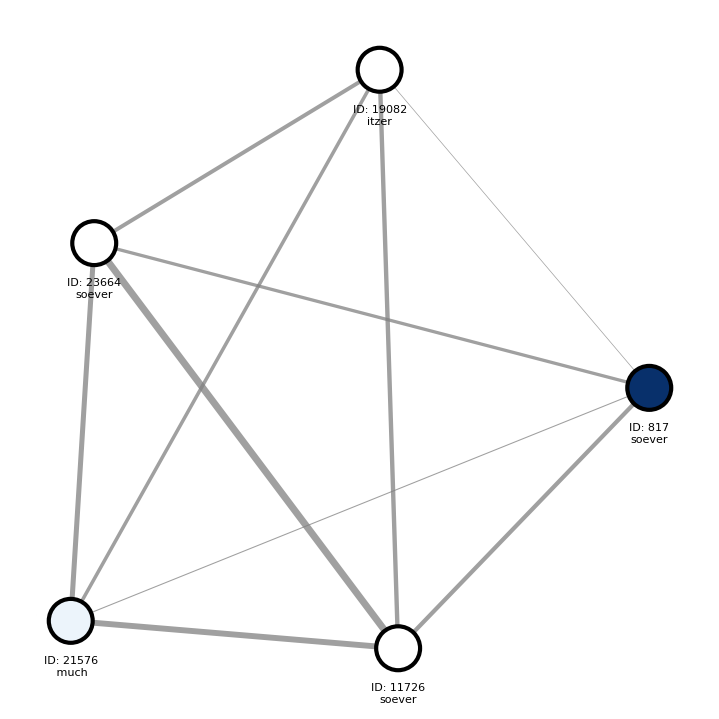

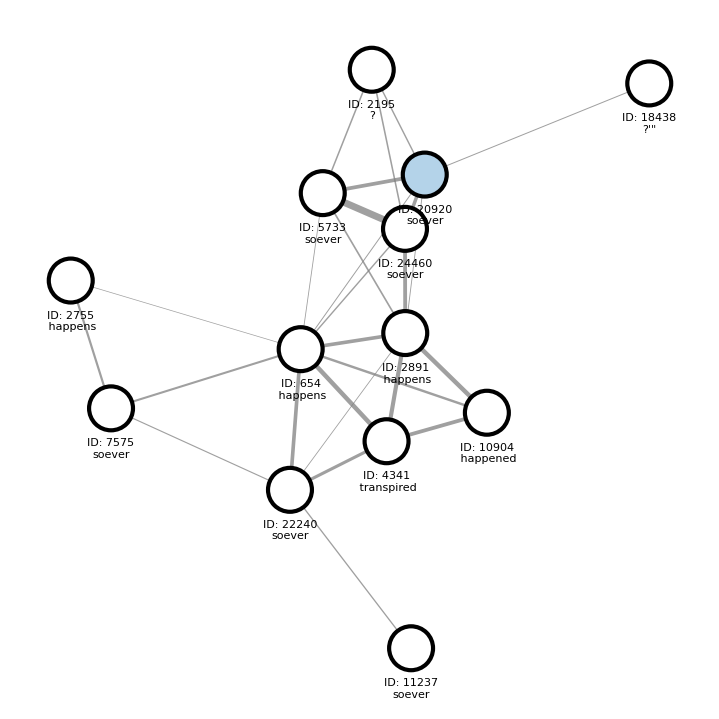

Number of non-zero features: 34
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 30.3542
Mean activation of non-zero non-feature splitting nodes: 2.4588
Median activation of non-zero feature splitting nodes: 30.3542
Median activation of non-zero non-feature splitting nodes: 1.0248
Number of splitting features active above threshold: 2
Number of non-splitting features active above threshold: 15
Sum of activation strengths for splitting features: 60.7084
Sum of activation strengths for non-splitting features: 78.6827


In [20]:
plot_feature_activations(
    get_point_result(results, 2),
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    save_figs=False,
    pca_path=pca_path,
)

In [21]:
# Usage example:
pca_df, _ = perform_pca_on_results(results)
analyze_representative_points(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing representative point 1:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 50
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 36.8451
Mean activation of non-zero non-feature splitting nodes: 1.9970
Median activation of non-zero feature splitting nodes: 36.8451
Median activation of non-zero non-feature splitting nodes: 1.0605
Number of splitting features active above threshold: 2
Number of non-splitting features active above threshold: 21
Sum of activation strengths for splitting features: 73.6901
Sum of activation strengths for non-splitting features: 95.8539

Analyzing representative point 2:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 60
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 37.9955
Mean activation of non-zero non-feature splitting nodes: 1.5798
Median activation of non-zero feature splitting nodes: 37.9955
Median activation of non-zero non-feature splitting nodes: 1.4503
Number of splitting features active above threshold: 2
Number of non-splitting features active above threshold: 27
Sum of activation strengths for splitting features: 75.9909
Sum of activation strengths for non-splitting features: 91.6304

Analyzing representative point 3:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 49
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 32.1299
Mean activation of non-zero non-feature splitting nodes: 2.2984
Median activation of non-zero feature splitting nodes: 32.1299
Median activation of non-zero non-feature splitting nodes: 1.3049
Number of splitting features active above threshold: 1
Number of non-splitting features active above threshold: 22
Sum of activation strengths for splitting features: 64.2598
Sum of activation strengths for non-splitting features: 108.0253

Analyzing representative point 4:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 45
Number of non-zero feature splitting nodes: 1
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 4.0298
Mean activation of non-zero non-feature splitting nodes: 2.9064
Median activation of non-zero feature splitting nodes: 4.0298
Median activation of non-zero non-feature splitting nodes: 1.2966
Number of splitting features active above threshold: 1
Number of non-splitting features active above threshold: 20
Sum of activation strengths for splitting features: 4.0298
Sum of activation strengths for non-splitting features: 127.8814

Analyzing representative point 5:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Number of non-zero features: 55
Number of non-zero feature splitting nodes: 3
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 19.7629
Mean activation of non-zero non-feature splitting nodes: 1.5925
Median activation of non-zero feature splitting nodes: 22.9595
Median activation of non-zero non-feature splitting nodes: 1.4434
Number of splitting features active above threshold: 3
Number of non-splitting features active above threshold: 24
Sum of activation strengths for splitting features: 59.2888
Sum of activation strengths for non-splitting features: 82.8101


In [22]:
# analyze_representative_points_comp(
#     results,
#     fs_splitting_nodes,
#     activation_threshold,
#     node_df,
#     pca_df,
#     save_figs=True,
#     pca_path=pca_path,
# )


Statistics for representative point 1:
Number of non-zero features: 50
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 36.8451
Mean activation of non-zero non-feature splitting nodes: 1.9970
Median activation of non-zero feature splitting nodes: 36.8451
Median activation of non-zero non-feature splitting nodes: 1.0605
Number of splitting features active above threshold: 2
Number of non-splitting features active above threshold: 21
Sum of activation strengths for splitting features: 73.6901
Sum of activation strengths for non-splitting features: 95.8539

Statistics for representative point 2:
Number of non-zero features: 60
Number of non-zero feature splitting nodes: 2
Total number of feature splitting nodes: 5
Mean activation of non-zero feature splitting nodes: 37.9955
Mean activation of non-zero non-feature splitting nodes: 1.5798
Median activation of non-zero feature splitting nodes: 37.99

In [23]:
pca_df

PC1        PC2       PC3 tokens  \
0    -16.469536   6.041056 -4.268339    how   
1     28.396292  -4.332845  0.428801    Too   
2    -22.621616 -22.628521  4.168482    how   
3     28.462774  -0.844647  1.582187    way   
4    -10.932577  10.551300  5.822938    how   
...         ...        ...       ...    ...   
1246  -7.406391   6.933765 -5.293441    how   
1247 -16.073072   7.043411 -9.284070    how   
1248 -12.108599  11.109418 -3.089801    how   
1249  -3.930549   9.409295 -3.648804    how   
1250  32.652142  -2.072368  0.547876   this   

                                                context  point_id  
0            ��s not clear| how| much a small change in         0  
1      the donation request began.| Too| many Republ...         1  
2                   m an angry voter,| how| ��bout that         2  
3     �m angry about the| way| the country is workin...         3  
4      — perhaps a preview of| how| competitive the ...         4  
...                                                 ...       ...  
1246   Hugh Freeze stepping down and| how| "bizarre"...      1246  
1247   looking for answers as to| how| Ole Miss find...      1247  
1248   talk to. He explained| how| he became so inte...      1248  
1249          It's a story of| how| what began as a run      1249  
1250          't believe it has gotten| this| far.\n\n"      1250  

[1251 rows x 6 columns]

In [24]:
node_df.dtypes

node_id                       int64
activity_threshold          float64
subgraph_id                   int64
subgraph_size                 int64
feature_activations         float64
top_10_tokens                object
neuronpedia_link             object
density                     float64
max_avg_degree_ratio        float64
avg_clustering              float64
diameter                      int64
single_node_score           float64
hub_spoke_score             float64
strongly_connected_score    float64
linear_score                float64
quicklist_link               object
dtype: object

In [25]:
# just straight line
interesting_point_ids = [
    322,
    382,
    880,
    899,
    919,
    646,
]  # Replace with actual IDs of interest
analyze_specific_points_from_sparse_matrix_path(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,
    point_ids=interesting_point_ids,
    subdir="straight_line",
    plot_only_fs_nodes=True,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 322:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 382:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 880:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 899:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 919:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 646:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [26]:
# just straight line
interesting_point_ids = [
    322,
    382,
    880,
    899,
    919,
    646,
]  # Replace with actual IDs of interest
analyze_specific_points_animated(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,  # type: ignore
    interesting_point_ids,
    plot_only_fs_nodes=True,
    save_gif=True,
    gif_path=os.path.join(pca_path, "straight.gif"),
)

/Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight_gif_frames
Animation saved as GIF: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight.gif
Individual frames saved in folder: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight_gif_frames


In [27]:
# just straight line
interesting_point_ids = [
    322,
    404,
    88,
    1083,
    119,
    805,
    961,
    1054,
    412,
]  # Replace with actual IDs of interest
analyze_specific_points(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,
    interesting_point_ids,
    subdir="straight_line2",
    plot_only_fs_nodes=True,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 322:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 404:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 88:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 1083:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 119:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 805:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 961:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 1054:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 412:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [28]:
# just straight line
interesting_point_ids = [
    322,
    404,
    88,
    1083,
    119,
    805,
    961,
    1054,
]  # Replace with actual IDs of interest
analyze_specific_points_animated(
    results=results,
    fs_splitting_nodes=fs_splitting_nodes,
    fs_splitting_cluster=fs_splitting_cluster,
    activation_threshold=activation_threshold,
    node_df=node_df,
    results_path=results_path,
    pca_df=pca_df,  # type: ignore
    point_ids=interesting_point_ids,
    plot_only_fs_nodes=True,
    save_gif=True,
    gif_path=os.path.join(pca_path, "straight2.gif"),
)

/Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight2_gif_frames
Animation saved as GIF: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight2.gif
Individual frames saved in folder: /Users/matthew/Documents/Github/PIBBSS/figures/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/pca_1_5_subgraph_787/straight2_gif_frames


In [29]:
# After creating the PCA plot and identifying interesting points
interesting_point_ids = [
    322,
    1153,
    790,
    412,
    646,
    1176,
    919,
    880,
    382,
    899,
]  # Replace with actual IDs of interest
analyze_specific_points(
    results,
    fs_splitting_nodes,
    fs_splitting_cluster,
    activation_threshold,
    node_df,
    results_path,
    pca_df,
    interesting_point_ids,
    save_figs=True,
    pca_path=pca_path,
)


Analyzing point with ID 322:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 1153:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 790:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 412:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 646:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 1176:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 919:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 880:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 382:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.




Analyzing point with ID 899:


/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [30]:
# analyze_user_specified_points_comp(results, fs_splitting_nodes, activation_threshold, node_df, pca_df, interesting_point_ids, save_figs=True, pca_path=pca_path)

In [31]:
# analyze_user_specified_points_comp_subgraph(results, fs_splitting_nodes, fs_splitting_cluster, activation_threshold, node_df, pca_df, interesting_point_ids, results_path, save_figs=True, pca_path=pca_path)

In [32]:
plot_subgraph_static(
    load_subgraph(results_path, activation_threshold, subgraph_id),
    node_df,
    0.0,
    os.path.join(pca_path, "overall_subgraph"),
    overall_feature_activations,
    normalize_globally=False,
    save_figs=True,
)

/Users/matthew/Documents/Github/PIBBSS/PIBBSS/graph_generation.py:622: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



In [33]:
def plot_pca_how(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Define colors for each category with alpha
    alpha = 1

    color_map = {
        "No How": f"rgba(204, 204, 204, {alpha})",  # Light gray with 50% opacity
        "How": f"rgba(102, 178, 255, {alpha})",  # Light blue with 50% opacity
        "How + ?": f"rgba(255, 153, 153, {alpha})",  # Light red with 50% opacity
    }

    # Function to determine color based on context
    def get_color(context):
        context_lower = context.lower()
        if "how" in context_lower and "?" in context_lower:
            return color_map["How + ?"]
        elif "how" in context_lower:
            return color_map["How"]
        else:
            return color_map["No How"]

    # Apply the function to get colors
    pca_df["color"] = pca_df["context"].apply(get_color)

    # Create the plot
    fig = go.Figure()

    # Add traces for colors (categories)
    for category, color in color_map.items():
        df_category = pca_df[pca_df["color"] == color]
        fig.add_trace(
            go.Scatter(
                x=df_category["PC2"],
                y=df_category["PC3"],
                mode="markers",
                marker=dict(
                    color=color,
                    size=12,
                    line=dict(width=1, color="DarkSlateGrey"),  # Remove outline
                ),
                name=category,
                text=[
                    f"Token: {t}<br>Context: {c}"
                    for t, c in zip(df_category["tokens"], df_category["context"])
                ],
                hoverinfo="text",
            )
        )

    # Update layout
    fig.update_layout(
        height=800,
        width=800,
        title_text=f"PCA Analysis - Cluster {fs_splitting_cluster} (Context Categories)",
        xaxis_title="PC2",
        yaxis_title="PC3",
        legend=dict(title="Context Category", groupclick="toggleitem"),
    )

    if save_figs:
        # Save as PNG
        png_path = os.path.join(
            pca_path, f"pca_plot_context_categories_{fs_splitting_cluster}.png"
        )
        fig.write_image(png_path, scale=3.0)

        # Save as HTML
        html_path = os.path.join(
            pca_path, f"pca_plot_context_categories_{fs_splitting_cluster}.html"
        )
        fig.write_html(html_path)
    else:
        fig.show()

    return fig

In [34]:
plot_pca_how(pca_df, pca_path, fs_splitting_cluster, save_figs=True)

In [35]:
pca_df_max_examples = pca_df.copy()  # type: ignore
pca_df_max_examples["combined"] = (
    pca_df_max_examples["PC2"] + pca_df_max_examples["PC3"]
)
examples = pca_df_max_examples.sort_values("combined", ascending=False).head(10)
examples.rename(columns={"context": "Context"}, inplace=True)
# show only columns for point id and context
examples[["Context"]].to_csv(pj(pca_path, "top_examples_right.csv"), index=False)

In [36]:
pca_df_max_examples = pca_df.copy()  # type: ignore
pca_df_max_examples["combined"] = -pca_df_max_examples["PC2"]
examples = pca_df_max_examples.sort_values("combined", ascending=False).head(10)
examples.rename(columns={"context": "Context"}, inplace=True)
# Remove special characters, including \n and \\n, from 'Context' before export
examples["Context"] = examples["Context"].str.replace("\n", "").str.replace("\\n", "")
# show only columns for point id and context
examples[["Context"]].to_csv(pj(pca_path, "top_examples_left.csv"), index=False)
examples

PC1        PC2       PC3 tokens  \
646  -29.771870 -27.612747  3.272074    How   
1076 -32.455547 -27.304342  2.891099    How   
46   -27.609953 -26.747528  3.166392    How   
845  -27.406618 -26.666136  3.156459    How   
764  -28.077402 -26.349483  2.972483    How   
1032 -29.972712 -26.325798  2.775354    How   
1140 -29.572796 -26.316528  2.811665    How   
1105 -28.503813 -26.233433  3.201705    How   
44   -25.830229 -26.035246  3.079411    How   
567  -29.302664 -25.848043  2.664963    How   

                                                Context  point_id  \
646                       .AG:| How| did you guys meet?       646   
1076                 was wrong.|How| is it that you can      1076   
46          10, top panel).| How| bad is his rampage of        46   
845     chosen representative.|How| important are early       845   
764    third quarter.|How| much Orange County housin...       764   
1032        new isn't new?| How| do you not realize you      1032   
1140     <|endoftext|> said. ��|How| do you say that to      1140   
1105                 smith: Good morning.| How| are ya?      1105   
44     a rotten parking job.| How|'s that red truck ...        44   
567   <|endoftext|> this gas station.| How| about it?��       567   

                       color   combined  
646   rgba(255, 153, 153, 1)  27.612747  
1076  rgba(102, 178, 255, 1)  27.304342  
46    rgba(102, 178, 255, 1)  26.747528  
845   rgba(102, 178, 255, 1)  26.666136  
764   rgba(102, 178, 255, 1)  26.349483  
1032  rgba(255, 153, 153, 1)  26.325798  
1140  rgba(102, 178, 255, 1)  26.316528  
1105  rgba(255, 153, 153, 1)  26.233433  
44    rgba(102, 178, 255, 1)  26.035246  
567   rgba(255, 153, 153, 1)  25.848043

In [37]:
pca_df_max_examples = pca_df.copy()  # type: ignore
pca_df_max_examples["combined"] = (
    -pca_df_max_examples["PC2"] + pca_df_max_examples["PC3"]
)
examples = pca_df_max_examples.sort_values("combined", ascending=False).head(10)
examples.rename(columns={"context": "Context"}, inplace=True)
# show only columns for point id and context
examples[["Context"]].to_csv(pj(pca_path, "top_examples_bottom.csv"), index=False)

In [38]:
# interesting_point_ids = [322, 1153, 790, 412, 646, 1176, 919, 880, 382, 899]
# plot_data = analyze_specific_points_animation(
#     results,
#     fs_splitting_nodes,
#     fs_splitting_cluster,
#     activation_threshold,
#     node_df,
#     results_path,
#     pca_df,
#     interesting_point_ids,
# )

# # Usage example
# pca_fig, bar_fig = create_animated_plots(plot_data)

# # Display or save the figures
# pca_fig.show()
# bar_fig.show()

# # Optionally, save as HTML for interactive viewing
# pca_fig.write_html("pca_animation.html")
# bar_fig.write_html("bar_plot_animation.html")

ImportError: cannot import name 'analyze_specific_points_animation' from 'PIBBSS.pca' (/Users/matthew/Documents/Github/PIBBSS/PIBBSS/pca.py)

In [44]:
results.all_graph_feature_acts.shape

torch.Size([1251, 5])

In [40]:
pca_df

PC1        PC2       PC3 tokens  \
0    -16.469536   6.041056 -4.268339    how   
1     28.396292  -4.332845  0.428801    Too   
2    -22.621616 -22.628521  4.168482    how   
3     28.462774  -0.844647  1.582187    way   
4    -10.932577  10.551300  5.822938    how   
...         ...        ...       ...    ...   
1246  -7.406391   6.933765 -5.293441    how   
1247 -16.073072   7.043411 -9.284070    how   
1248 -12.108599  11.109418 -3.089801    how   
1249  -3.930549   9.409295 -3.648804    how   
1250  32.652142  -2.072368  0.547876   this   

                                                context  point_id  \
0            ��s not clear| how| much a small change in         0   
1      the donation request began.| Too| many Republ...         1   
2                   m an angry voter,| how| ��bout that         2   
3     �m angry about the| way| the country is workin...         3   
4      — perhaps a preview of| how| competitive the ...         4   
...                                                 ...       ...   
1246   Hugh Freeze stepping down and| how| "bizarre"...      1246   
1247   looking for answers as to| how| Ole Miss find...      1247   
1248   talk to. He explained| how| he became so inte...      1248   
1249          It's a story of| how| what began as a run      1249   
1250          't believe it has gotten| this| far.\n\n"      1250   

                       color  
0     rgba(102, 178, 255, 1)  
1     rgba(204, 204, 204, 1)  
2     rgba(102, 178, 255, 1)  
3     rgba(204, 204, 204, 1)  
4     rgba(102, 178, 255, 1)  
...                      ...  
1246  rgba(102, 178, 255, 1)  
1247  rgba(102, 178, 255, 1)  
1248  rgba(102, 178, 255, 1)  
1249  rgba(102, 178, 255, 1)  
1250  rgba(204, 204, 204, 1)  

[1251 rows x 7 columns]

In [73]:
# Assuming results.all_graph_feature_acts is a 2D array where each row corresponds to a token in pca_df
# and pca_df has a column 'tokens' that matches the order of activations.

# Create a DataFrame for feature activations with column names based on fs_splitting_nodes
feature_activations_df = pd.DataFrame(
    results.all_graph_feature_acts.cpu().numpy(),
    columns=[f"feature_{node}" for node in fs_splitting_nodes],
)

# Merge the two DataFrames completely
merged_df = pd.concat([feature_activations_df, pca_df], axis=1)

# Display the merged DataFrame
print(merged_df)

      feature_21576  feature_19082  feature_11726  feature_23664  feature_817  \
0          8.367745       7.465953      35.216961       0.864527     3.451518   
1          0.000000       0.000000       0.000000       0.000000     5.389631   
2          3.357349       0.000000       0.000000       0.000000    57.351040   
3          4.225954       0.000000       1.484829       0.000000     0.000000   
4         26.325428       0.000000      13.942617      10.836637     0.000000   
...             ...            ...            ...            ...          ...   
1246       3.478316       0.000000       1.194145      37.577244     4.987249   
1247       0.000000       6.872403      29.110954      16.850212     2.507248   
1248       7.622016       8.827356       0.000000      36.917725     0.000000   
1249       6.981405       0.000000       0.000000      36.759865     0.000000   
1250       0.881363       0.000000       0.000000       0.000000     0.000000   

            PC1        PC2 

In [60]:
# Sort the merged DataFrame by PC3
sorted_df = merged_df.sort_values(by="PC2")
# filter for features 21576 and 817
sorted_df = sorted_df[["PC2", "feature_21576", "feature_817"]]
sorted_df

PC2  feature_21576  feature_817
646  -27.612747       0.000000    68.110985
1076 -27.304342       0.000000    68.899666
46   -26.747528       0.000000    65.779854
845  -26.666136       0.000000    65.560616
764  -26.349483       0.000000    65.392952
...         ...            ...          ...
965   15.592678      57.133629     0.000000
774   15.879317      51.781055     0.000000
322   16.446781      62.863277     0.000000
404   16.745623      49.996689     0.000000
1069  17.412266      58.161644     0.000000

[1251 rows x 3 columns]

In [67]:
# Create a Plotly figure
fig = go.Figure()

# Add traces for each feature
for column in sorted_df.columns[1:]:  # Exclude PCA columns and 'tokens'
    fig.add_trace(
        go.Scatter(
            x=sorted_df["PC2"],
            y=sorted_df[column],
            mode="lines",
            line_shape="spline",
            name=column,
        )
    )

# Update layout
fig.update_layout(
    title="Feature Activation Strength from Min to Max PC2",
    xaxis_title="PC2",
    yaxis_title="Feature Activation Strength",
    legend_title="Features",
    template="plotly_white",
)

# Show the figure
fig.show()


fig.write_html(pj(pca_path, "feature_activation_strength_from_min_to_max_pc2.html"))
fig.write_image(pj(pca_path, "feature_activation_strength_from_min_to_max_pc2.png"))
fig.write_image(pj(pca_path, "feature_activation_strength_from_min_to_max_pc2.pdf"))

In [66]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for each feature
for column in sorted_df.columns[1:]:  # Exclude PCA columns and 'tokens'
    fig.add_trace(
        go.Scatter(
            x=sorted_df["PC2"],
            y=sorted_df[column],
            mode="lines",
            line_shape="spline",
            name=column,
            stackgroup="one",  # This makes it a stacked area plot
        )
    )

# Update layout
fig.update_layout(
    title="Stacked Feature Activation Strength from Min to Max PC2",
    xaxis_title="PC2",
    yaxis_title="Cumulative Feature Activation Strength",
    legend_title="Features",
    template="plotly_white",
)

# Show the figure
fig.show()

In [70]:
# Sort the merged DataFrame by PC3
sorted_df = merged_df.sort_values(by="PC3")
# filter for features 21576 and 817
# sorted_df = sorted_df[['PC2', 'feature_21576', 'feature_817']]

In [76]:
# Create a Plotly figure
fig = go.Figure()

# Add traces for each feature
for column in sorted_df.columns[:-7]:  # Exclude PCA columns and 'tokens'
    fig.add_trace(
        go.Scatter(
            x=sorted_df["PC3"],
            y=sorted_df[column],
            mode="lines",
            line_shape="spline",
            name=column,
            # stackgroup='one'
        )
    )

# Update layout
fig.update_layout(
    title="Feature Activation Strength from Min to Max PC3",
    xaxis_title="PC3",
    yaxis_title="Feature Activation Strength",
    legend_title="Features",
    template="plotly_white",
)

# Show the figure
fig.show()


fig.write_html(pj(pca_path, "feature_activation_strength_from_min_to_max_pc3.html"))
fig.write_image(pj(pca_path, "feature_activation_strength_from_min_to_max_pc3.png"))
fig.write_image(pj(pca_path, "feature_activation_strength_from_min_to_max_pc3.pdf"))

In [26]:
interesting_point_ids = [
    322,
    382,
    880,
    899,
    919,
    646,
]

plot_feature_activation_trends_representative_points(
    results,
    fs_splitting_nodes,
    interesting_point_ids,
    pca_df,  # type: ignore
    save_figs=True,
    pca_path=pca_path,
    context_before=1,
    context_after=25,
)

In [23]:
plot_feature_activation_trends_horizontal(
    results,
    fs_splitting_nodes,
    interesting_point_ids,
    pca_df,  # type: ignore
    save_figs=True,
    pca_path=pca_path,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
